<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
تشخیص اخبار دروغین
</font>
</h1>

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
وارد کردن کتابخانه‌های مورد نیاز
</font>
</h2>

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as ss
import seaborn as sns
import  matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
معرفی مجموعه داده
</font>
</h2>
<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در فایل <code>news_train.csv</code> اطلاعات کلی مانند زمان انتشار، منبع و برچسب خبر آمده است؛ اما خود خبر را در این مجموعه‌داده نداریم. بلکه خود خبر را می‌توان در فایل <code>news_train_text_vectors.npz</code> جستجو کرد. اما در <code>news_train_text_vectors.npz</code> متن خبر قرار نگرفته است، بلکه به کمک روش‌های پردازش زبان طبیعی، متن هر خبر را به یک بردار ۴۲۱۴۱ المانی تبدیل کرده‌ایم و به ازای هر خبر، یک بردار با ابعاد <code>(42141, 1)</code> وجود دارد.

</font>
</p>

In [2]:
train_data = pd.read_csv('../data/news_train.csv')
train_data_text_vectors = ss.load_npz('../data/news_train_text_vectors.npz')

test_data = pd.read_csv('../data/news_test.csv')
test_data_text_vectors = ss.load_npz('../data/news_test_text_vectors.npz')

In [3]:
train_data_text_vectors = pd.DataFrame(train_data_text_vectors.toarray(),
                                        columns = ['token'+str(i) for i in range(train_data_text_vectors.shape[1])])

In [4]:
test_data_text_vectors = pd.DataFrame(test_data_text_vectors.toarray(),
                                        columns = ['token'+str(i) for i in range(train_data_text_vectors.shape[1])])

<b>VISUALIZE

In [5]:
train_data_text_vectors.shape # (1500, 42141)
train_data.shape # (1500, 5)
test_data_text_vectors.shape # (346, 42141)
test_data.shape # (346, 4)

(346, 4)

In [6]:
train_data.head()

,author,published,site_url,type,label
0,No Author,2016-11-01T03:28:50.389+02:00,clickhole.com,satire,Fake
1,Anonymous,2016-10-27T21:30:00.000+03:00,abeldanger.net,bs,Fake
2,Kali74,2016-10-27T02:54:49.093+03:00,abovetopsecret.com,bs,Fake
3,Alex Ansary,2016-11-04T22:44:06.026+02:00,amtvmedia.com,bs,Fake
4,Luke Stranahan,2016-11-23T15:10:56.702+02:00,returnofkings.com,hate,Real


In [7]:
train_data.describe()

,author,published,site_url,type,label
count,1500,1500,1500,1500,1500
unique,418,1439,61,7,2
top,No Author,2016-10-30T13:00:00.000+02:00,prisonplanet.com,bs,Fake
freq,318,8,89,423,988


In [8]:
train_data['author'].value_counts(sort=True, ascending=False)

author
No Author                      318
Activist Post                   64
EdJenner                        57
Anonymous                       44
Daniel Greenfield               44
                              ... 
Bruce Thornton                   1
Robert Franek                    1
Hesh Goldstein                   1
greanfinisher .                  1
theeconomiccollapseblog.com      1
Name: count, Length: 418, dtype: int64

In [9]:
train_data['label'].value_counts()/ train_data.shape[0] *100

label
Fake    65.866667
Real    34.133333
Name: count, dtype: float64

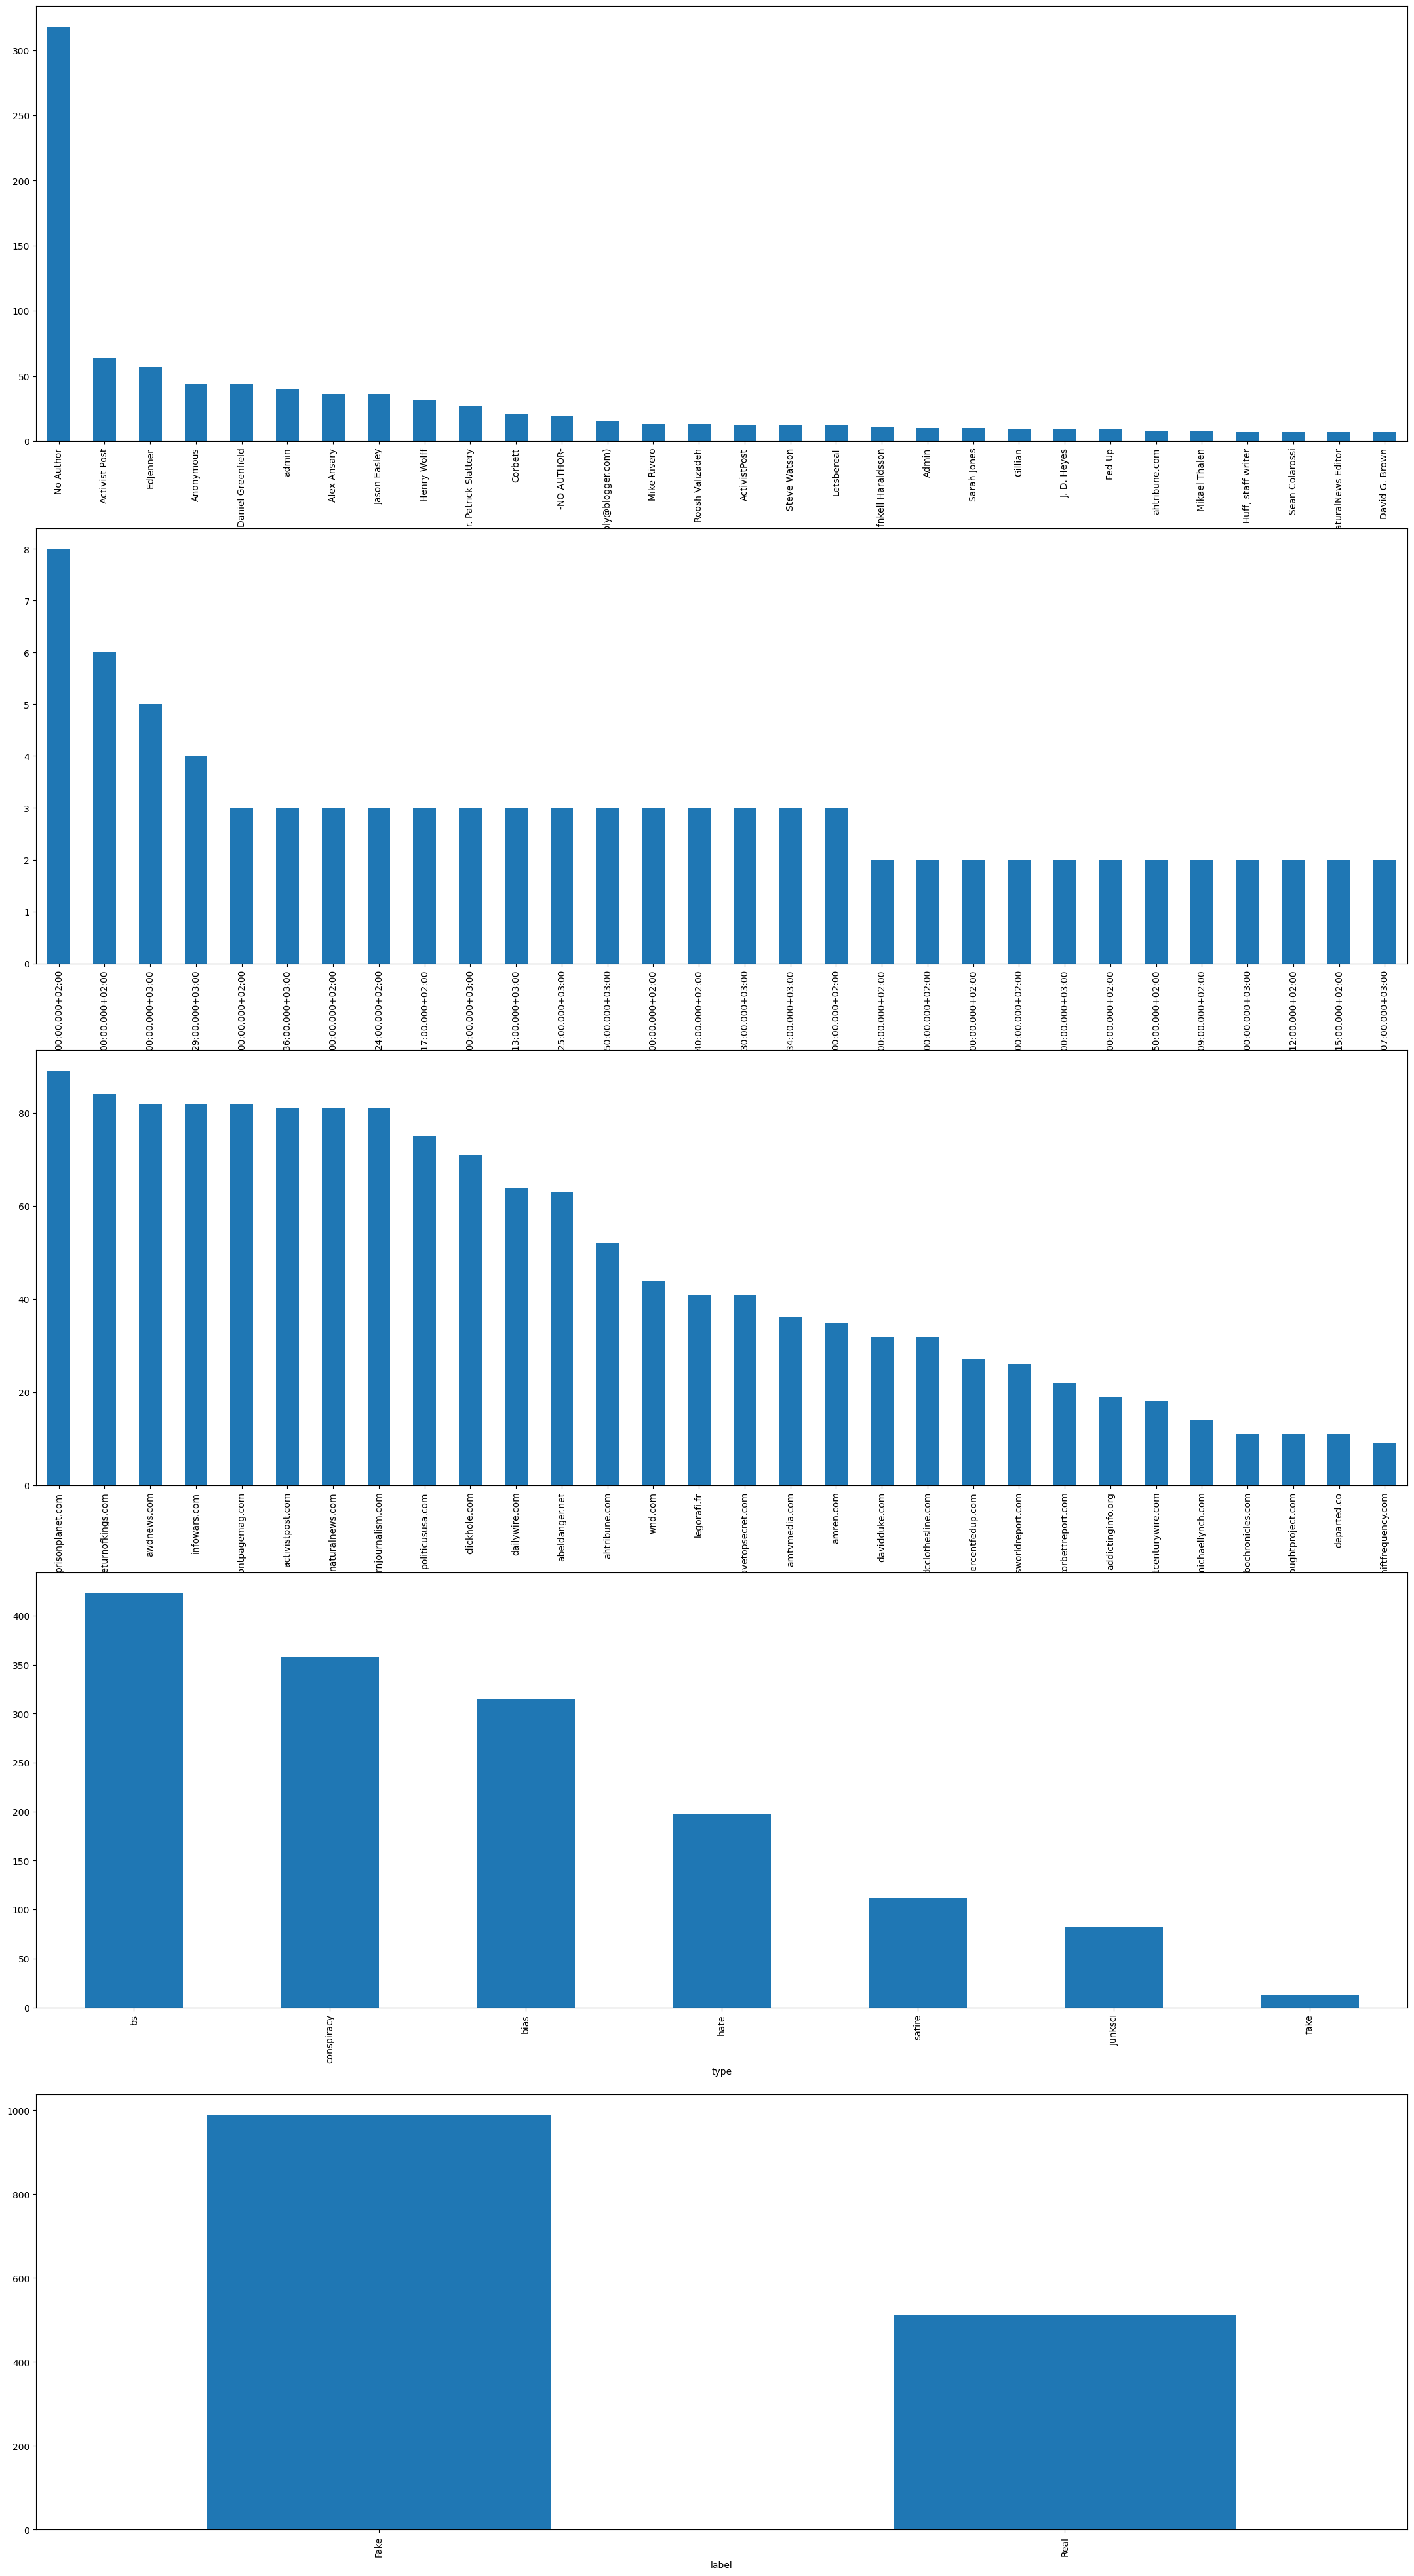

In [10]:
fig, axes = plt.subplots(5 , figsize=(27,50))
i=0
for col in train_data.columns:
    train_data[col].value_counts()[:30].plot.bar(ax =axes[i])
    i += 1


<b>پیش پردازش

In [11]:
train ,valid = train_test_split(train_data, train_size=.8)

In [12]:
train_text_vector = train_data_text_vectors.loc[train.index]
valid_text_vector = train_data_text_vectors.loc[valid.index]

In [13]:
class Preprocessor:
    def __init__(self):
        pass

    def detect_suspicious_site_urls(self, thresh=.5):
        sit_url_status = self.df.replace({'label': {'Fake':1, 'Real':0}}).groupby('site_url')['label'].mean()
        suspicious_sites = sit_url_status[sit_url_status >= thresh].index.tolist()
        not_suspicious_sites = sit_url_status[sit_url_status < thresh].index.tolist()

        return suspicious_sites, not_suspicious_sites

    def detect_suspicious_type(self, thresh=.5):
        type_status = self.df.replace({'label': {'Fake':1, 'Real':0}}).groupby('type')['label'].mean()
        suspicious_type = type_status[type_status >= thresh].index.tolist()
        not_suspicious_type = type_status[type_status < thresh].index.tolist()

        return suspicious_type, not_suspicious_type

    def detect_suspicious_authors(self, thresh=.5):
        author_status = self.df.replace({'label': {'Fake':1, 'Real':0}}).groupby('author')['label'].mean()
        suspicious_author = author_status[author_status >= thresh].index.tolist()
        not_suspicious_author = author_status[author_status < thresh].index.tolist()

        return suspicious_author, not_suspicious_author

    def transform(self, dataframe:pd.DataFrame, is_train=False):
        self.df = dataframe.copy()

        if is_train:
            self.suspicious_sites, self.not_suspicious_sites = self.detect_suspicious_site_urls()
            self.suspicious_type, self.not_suspicious_type = self.detect_suspicious_type()
            self.suspicious_author, self.not_suspicious_author = self.detect_suspicious_authors()
        if not is_train and(not hasattr(self, 'suspicious_sites') or not hasattr(self, 'suspicious_type') or not hasattr(self, 'suspicious_author')):
            raise AttributeError("suspicious field required! call 'transform' method with 'is_train' param set to True")

        self.df['is_suspicious_site_url'] = None
        self.df.loc[self.df['site_url'].isin(self.suspicious_sites), 'is_suspicious_site_url'] = 1
        self.df.loc[self.df['site_url'].isin(self.not_suspicious_sites), 'is_suspicious_site_url'] = -1
        self.df['is_suspicious_site_url'].fillna(0, inplace=True)

        self.df['is_suspicious_type'] = None
        self.df.loc[self.df['type'].isin(self.suspicious_type), 'is_suspicious_type'] = 1
        self.df.loc[self.df['type'].isin(self.not_suspicious_type), 'is_suspicious_type'] = -1
        self.df['is_suspicious_type'].fillna(0, inplace=True)

        self.df['is_suspicious_author'] = None
        self.df.loc[self.df['author'].isin(self.suspicious_author), 'is_suspicious_author'] = 1
        self.df.loc[self.df['author'].isin(self.not_suspicious_author), 'is_suspicious_author'] = -1
        self.df['is_suspicious_author'].fillna(0, inplace=True)

        self.df.drop(columns=['author', 'published', 'site_url', 'type'], inplace=True)

        return self.df

In [14]:
preprocessor = Preprocessor()

In [15]:
preprocessed_train = preprocessor.transform(train, is_train=True)
preprocessed_valid = preprocessor.transform(valid)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13016\2059973605.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sit_url_status = self.df.replace({'label': {'Fake':1, 'Real':0}}).groupby('site_url')['label'].mean()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13016\2059973605.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  type_status = self.df.replace({'label': {'Fake':1, 'Real':0}}).groupby('type')['label'].mean()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13016\2059973605.py:20: FutureWarning: Downcasting behavior in `r

In [18]:
preprocessed_train.isna().sum()
preprocessed_valid.isna().sum()

label                     0
is_suspicious_site_url    0
is_suspicious_type        0
is_suspicious_author      0
dtype: int64

<Axes: >

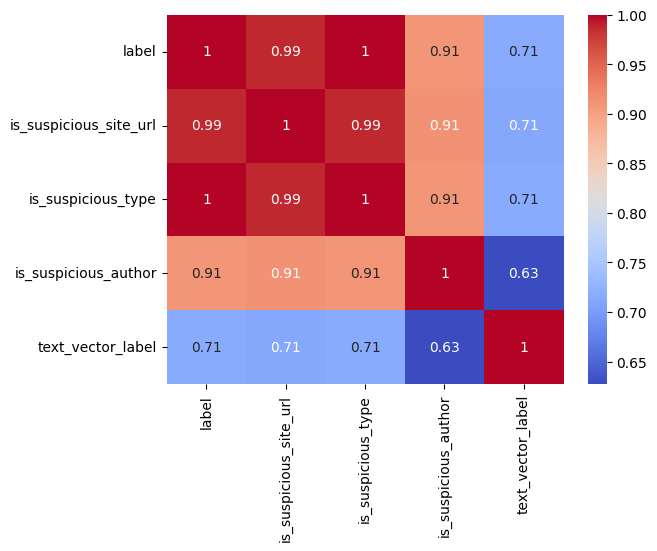

In [ ]:
import seaborn as sns
visualize_data = preprocessed_train.copy()
visualize_data['label'] = visualize_data['label'].map({'Real':0, 'Fake':1})
corr = visualize_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [17]:
pca = PCA(n_components=600)
pca.fit(train_text_vector)
reduced_train_text_vectors = pca.transform(train_text_vector)
reduced_valid_text_vectors = pca.transform(valid_text_vector)

<b> مدل سازی

In [19]:
(reduced_train_text_vectors==0).sum() / reduced_train_text_vectors.shape[0] * reduced_train_text_vectors.shape[1] 
#  reduced train text vectors is not sparse so I choose linear regression.

0.0

In [20]:
vector_model = LogisticRegression()
vector_model.fit(reduced_train_text_vectors, preprocessed_train['label'].map({'Real':0, 'Fake':1}))

LogisticRegression()

In [21]:
y_pred = vector_model.predict(reduced_valid_text_vectors)
y = preprocessed_valid['label'].map({'Real':0, 'Fake':1})
f1_score(y_pred , y )

0.826271186440678

In [22]:
preprocessed_train['text_vector_label'] = vector_model.predict(reduced_train_text_vectors)
preprocessed_valid['text_vector_label'] = vector_model.predict(reduced_valid_text_vectors)

In [23]:
final_model = LogisticRegression(fit_intercept=True)
final_model.fit(preprocessed_train.drop(columns=['label']), preprocessed_train['label'].map({'Real':0, 'Fake':1}))

LogisticRegression()

In [24]:
y_pred = final_model.predict(preprocessed_valid.drop(columns=['label']))
y = preprocessed_valid['label'].map({'Real':0, 'Fake':1})
f1_score(y_pred , y )

1.0

In [25]:
preprocessed_test = preprocessor.transform(test_data)
reduced_test_text_vectors = pca.transform(test_data_text_vectors)
preprocessed_test['text_vector_label'] = vector_model.predict(reduced_test_text_vectors)
test_label = final_model.predict(preprocessed_test)
test_label = pd.Series(test_label).map({1: "Fake", 0: "Real"})

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13016\2059973605.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df['is_suspicious_site_url'].fillna(0, inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13016\2059973605.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['is_suspicious_s

In [26]:
test_label

0      Real
1      Fake
2      Real
3      Real
4      Real
       ... 
341    Fake
342    Real
343    Fake
344    Fake
345    Fake
Length: 346, dtype: object